
---
# Load needed libraries and functions

In [1]:

%run ../../load_magic/storage.py
%run ../../load_magic/environment.py
from scipy.stats import entropy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
import inspect
import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import numpy as np
import time
%pprint

notebook_path = get_notebook_path()
print(notebook_path)

s = Storage()
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])
basic_quals_dict = s.load_object('basic_quals_dict')
dir()

Pretty printing has been turned OFF
D:\Documents\Repositories\notebooks\Miscellaneous\ipynb\Tune Logit Hyper-parameters.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']


['Config', 'CountVectorizer', 'In', 'LogisticRegression', 'Out', 'RandomForestClassifier', 'Storage', 'TfidfTransformer', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '_dh', '_i', '_i1', '_ih', '_ii', '_iii', '_oh', 'basic_quals_dict', 'csv', 'entropy', 'exit', 'get_classifier', 'get_data_structs_dataframe', 'get_datastructure_prediction', 'get_dir_tree', 'get_importances', 'get_input_sample', 'get_ipython', 'get_module_version', 'get_notebook_path', 'get_struct_name', 'inspect', 'ipykernel', 'json', 'jupyter_config_dir', 'notebook_path', 'notebookapp', 'np', 'os', 'pd', 'pickle', 'plt', 'preprocess_data', 'quit', 're', 's', 'sys', 'time', 'urllib']

In [ ]:

!start %windir%\explorer.exe "{os.path.abspath(os.path.dirname(notebook_path))}"

In [ ]:

py_folder = os.path.abspath(os.path.join(notebook_path, '../../py'))
for sub_directory, directories_list, files_list in os.walk(py_folder):
    for file_name in files_list:
        if file_name.endswith('.py') and file_name.startswith('penalty_'):
            print()
            print('cd {}'.format(py_folder))
            print('{sys.executable} {file_name}'.format(sys=sys, file_name=file_name))


---
# Needed extra functions

In [2]:

scanner_regex = re.compile(r'\b[1-9a-zA-Z][0-9a-zA-Z]*( *[#\+]{1,2}|\b)')
def regex_tokenizer(corpus):
    
    return [match.group() for match in re.finditer(scanner_regex, corpus)]


---
# Training

In [3]:

# Rebuild the datframe from the dictionary
rows_list = [{'qualification_str': qualification_str, 'is_fit': is_fit} for qualification_str, is_fit in basic_quals_dict.items()]
basic_quals_df = pd.DataFrame(rows_list)
s.store_objects(basic_quals_df=basic_quals_df)

# Re-transform the bag-of-words and tf-idf from the new manual scores
sents_list = basic_quals_df.qualification_str.tolist()

# Bag-of-words
cv = CountVectorizer(lowercase=True, tokenizer=regex_tokenizer, token_pattern=r'\b[1-9a-zA-Z][0-9a-zA-Z]*[#\+]{0,2}', ngram_range=(1, 3))
bow_matrix = cv.fit_transform(sents_list)
s.store_objects(bq_cv_vocab=cv.vocabulary_)

# Tf-idf, must get from BOW first
tt = TfidfTransformer()
tfidf_matrix = tt.fit_transform(bow_matrix)
s.store_objects(bq_tt=tt)

# Re-train the classifier
X = tfidf_matrix.toarray()
y = basic_quals_df.is_fit.to_numpy()
fit_estimators_dict = s.load_object('fit_estimators_dict')
basic_quals_clf = fit_estimators_dict['LogisticRegression']
basic_quals_clf.fit(X, y)
s.store_objects(basic_quals_clf=basic_quals_clf)

# Re-calibrate the inference engine
bq_cv_vocab = s.load_object('bq_cv_vocab')
bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
bq_cv._validate_vocabulary()
bq_tt = s.load_object('bq_tt')
def predict_percent_fit(quals_list):
    y_predict_proba = np.array([])
    if len(quals_list):
        X_test = bq_tt.transform(bq_cv.transform(quals_list)).toarray()
        y_predict_proba = basic_quals_clf.predict_proba(X_test)
    
    return y_predict_proba
print('Retraining complete')

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\basic_quals_df.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\bq_cv_vocab.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\bq_tt.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\basic_quals_clf.pickle
Retraining complete



---
# Build a dataset of hyper-parameters

In [ ]:

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Bag-of-words
cv = CountVectorizer(lowercase=True, tokenizer=regex_tokenizer, token_pattern=r'\b[1-9a-zA-Z][0-9a-zA-Z]*[#\+]{0,2}', ngram_range=(1, 3))
bow_matrix = cv.fit_transform(sents_list)

# Tf-idf, must get from BOW first
tt = TfidfTransformer()
tfidf_matrix = tt.fit_transform(bow_matrix)

# Get the training data and models
X = tfidf_matrix.toarray()
y = basic_quals_df.is_fit.to_numpy()

In [4]:

kwargs_dict_list = [{'C': 7.5, 'class_weight': 'balanced', 'dual': True, 'fit_intercept': False, 'max_iter': 8,
                     'penalty': 'l2', 'solver': 'liblinear', 'tol': 1e-09},
                    {'C': 10.0, 'class_weight': 'balanced', 'dual': True, 'fit_intercept': True, 'intercept_scaling': 20, 'max_iter': 600,
                     'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001},
                    {'C': 10.0, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.001, 'warm_start': True},
                    {'C': 10.0, 'class_weight': None, 'max_iter': 250, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.0001},
                    {'class_weight': None, 'max_iter': 1000, 'penalty': 'none', 'solver': 'sag', 'tol': 0.001, 'warm_start': True},
                    {'C': 10.0, 'class_weight': 'balanced', 'l1_ratio': 0.5, 'max_iter': 250, 'penalty': 'elasticnet',
                     'solver': 'saga', 'tol': 0.001, 'warm_start': True}]

# Fit the data and add the duration and fitted models to lists
fit_logit_estimators_list = []
logit_training_durations_list = []
for kwarg in kwargs_dict_list:
    start_time = time.time()
    clf = LogisticRegression(**kwarg)
    fit_logit_estimators_list.append(clf.fit(X, y))
    stop_time = time.time()
    logit_training_durations_list.append(stop_time - start_time)
s.store_objects(logit_estimators_list=fit_logit_estimators_list, logit_training_durations_list=logit_training_durations_list)

C:\Users\577342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\577342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\577342\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\logit_estimators_list.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\logit_training_durations_list.pickle


In [5]:

logit_estimators_list = s.load_object('logit_estimators_list')
basic_quals_df = s.load_object('basic_quals_df')
logit_inference_durations_list = []
logit_predictions_dict = {}
for clf in logit_estimators_list:
    logit_predictions_list = []
    start_time = time.time()
    for row_index, row_series in basic_quals_df.iterrows():
        qualification_str = row_series.qualification_str
        X_test = bq_tt.transform(bq_cv.transform([qualification_str])).toarray()
        y_predict_proba = clf.predict_proba(X_test)[0][1]
        logit_predictions_list.append(y_predict_proba)
    stop_time = time.time()
    logit_predictions_dict[clf] = logit_predictions_list
    logit_inference_durations_list.append(stop_time - start_time)
s.store_objects(logit_predictions_dict=logit_predictions_dict, logit_inference_durations_list=logit_inference_durations_list)

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\logit_predictions_dict.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\logit_inference_durations_list.pickle


In [27]:

fit_logit_estimators_list = s.load_object('logit_estimators_list')
basic_quals_df = s.load_object('basic_quals_df')
y_true = basic_quals_df.is_fit.tolist()
fit_match_series = (basic_quals_df.is_fit == 1)
yes_list = basic_quals_df[fit_match_series].is_fit.tolist()
no_list = basic_quals_df[~fit_match_series].is_fit.tolist()
metrics_list = ['average_precision_score', 'precision_score', 'recall_score']
columns_list = ['kwargs_dict', 'training_duration', 'inference_duration'] + metrics_list
logit_training_durations_list = s.load_object('logit_training_durations_list')
logit_inference_durations_list = s.load_object('logit_inference_durations_list')
logit_predictions_dict = s.load_object('logit_predictions_dict')
exec('from sklearn.metrics import {}'.format(', '.join(metrics_list)))

In [28]:

rows_list = []
for kwargs_dict, clf, training_duration, inference_duration in zip(kwargs_dict_list, logit_predictions_dict.keys(),
                                                                   logit_training_durations_list, logit_inference_durations_list):
    y_pred = []
    logit_predictions_list = logit_predictions_dict[clf]
    for p in logit_predictions_list:
        if p > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
    row_dict = {}
    row_dict['kwargs_dict'] = kwargs_dict
    row_dict['training_duration'] = training_duration
    row_dict['inference_duration'] = inference_duration
    for metric_str in metrics_list:
        eval_str = '{}(y_true, y_pred)'.format(metric_str)
        try:
            row_dict[metric_str] = eval(eval_str)
        except Exception as e:
            print(eval_str)
            row_dict[metric_str] = np.nan
    rows_list.append(row_dict)

In [29]:

hyper_parameters_df = pd.DataFrame(rows_list, columns=columns_list).dropna(axis='columns', how='all')
hyper_parameters_df.set_index('kwargs_dict', drop=True, inplace=True)
s.store_objects(hyper_parameters_df=hyper_parameters_df)

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\hyper_parameters_df.pickle


In [30]:

hyper_parameters_df.sort_values('precision_score')

,training_duration,inference_duration,average_precision_score,precision_score,recall_score
kwargs_dict,,,,,
"{'C': 10.0, 'class_weight': None, 'max_iter': 250, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.0001}",369.221820,4.780097,0.773647,0.789449,0.932240
"{'C': 10.0, 'class_weight': 'balanced', 'dual': True, 'fit_intercept': True, 'intercept_scaling': 20, 'max_iter': 600, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}",0.868337,4.772818,0.799572,0.815890,0.937158
"{'C': 10.0, 'class_weight': 'balanced', 'l1_ratio': 0.5, 'max_iter': 250, 'penalty': 'elasticnet', 'solver': 'saga', 'tol': 0.001, 'warm_start': True}",100.871083,4.842142,0.798809,0.820626,0.917486
"{'C': 10.0, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.001, 'warm_start': True}",24.107744,4.808075,0.806917,0.823727,0.937158
"{'class_weight': None, 'max_iter': 1000, 'penalty': 'none', 'solver': 'sag', 'tol': 0.001, 'warm_start': True}",210.839157,4.835119,0.843285,0.881903,0.881421
"{'C': 7.5, 'class_weight': 'balanced', 'dual': True, 'fit_intercept': False, 'max_iter': 8, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1e-09}",0.615885,4.849435,0.827755,0.893333,0.805464



---
# Parameter estimation using grid search with cross-validation

The Logistic Regression classifier is optimized by cross-validation,
which is done using the :class:`sklearn.model_selection.GridSearchCV` object
on a development set that comprises only half of the available labeled quals data.

The performance of the selected hyper-parameters and trained model is
then measured on a dedicated evaluation set that was not used during
the model selection step.

(When a search engine returns 30 pages only 20 of which were relevant while failing to return 40 additional relevant pages, its precision is 20/30 = 2/3 while its recall is 20/60 = 1/3. So, in this case, precision is "how useful the search results are", and recall is "how complete the results are".)

In [6]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# To apply an classifier on this data, we need to
# turn the data in a (samples, feature) matrix:
X = tfidf_matrix.toarray()
y = basic_quals_df.is_fit.to_numpy()

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [
                    
                    # 'liblinear' and 'saga' handle L1 penalty
                    {'penalty': ['l1'],
                     'solver': ['liblinear', 'saga'],
                     'tol': [1e-5, 1e-4, 1e-3],
                     'C': [0.1, 1.0, 10.0],
                     'class_weight': [None, 'balanced'],
                     'max_iter': [10, 100, 1000]},
                    
                    # 'newton-cg', 'lbfgs', 'sag' and 'saga' handle L2 or no penalty
                    {'penalty': ['l2', 'none'],
                     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
                     'tol': [1e-5, 1e-4, 1e-3],
                     'C': [0.1, 1.0, 10.0],
                     'class_weight': [None, 'balanced'],
                     'max_iter': [10, 100, 1000],
                     'warm_start': [True]},
                    
                    # 'liblinear' does not support setting penalty='none'
                    {'penalty': ['l2'],
                     'solver': ['liblinear'],
                     'dual': [True, False],
                     'tol': [1e-5, 1e-4, 1e-3],
                     'C': [0.1, 1.0, 10.0],
                     'fit_intercept': [True],
                     'intercept_scaling': [1, 10, 100],
                     'class_weight': [None, 'balanced'],
                     'max_iter': [10, 100, 1000]},
                    {'penalty': ['l2'],
                     'solver': ['liblinear'],
                     'dual': [True, False],
                     'tol': [1e-5, 1e-4, 1e-3],
                     'C': [0.1, 1.0, 10.0],
                     'fit_intercept': [False],
                     'class_weight': [None, 'balanced'],
                     'max_iter': [10, 100, 1000]},
                    
                    # 'saga' also supports 'elasticnet' penalty
                    {'penalty': ['elasticnet'],
                     'solver': ['saga'],
                     'tol': [1e-5, 1e-4, 1e-3],
                     'C': [0.1, 1.0, 10.0],
                     'class_weight': [None, 'balanced'],
                     'max_iter': [10, 100, 1000],
                     'warm_start': [True],
                     'l1_ratio': [0, 0.5, 1]}]

In [ ]:

file_name = 'tuning_results.txt'
txt_dir = os.path.join(s.saves_folder, 'txt')
file_path = os.path.join(txt_dir, file_name)

# When a search engine returns 30 pages only 20 of which were relevant
# while failing to return 40 additional relevant pages, its precision
# is 20/30 = 2/3 while its recall is 20/60 = 1/3. So, in this case,
# precision is "how useful the search results are", and recall is
# "how complete the results are".
scores_list = ['precision', 'recall']

with open(file_path, 'w') as f:
    for score in scores_list:
        print('Tuning hyper-parameters for {}'.format(score), file=f)
        print('', file=f)

        clf = GridSearchCV(LogisticRegression(), tuned_parameters,
                           scoring='{}_macro'.format(score))
        clf.fit(X_train, y_train)

        print('Best parameters set found on development set:', file=f)
        print('', file=f)
        print(clf.best_params_, file=f)
        print('', file=f)
        print('Grid scores on development set:', file=f)
        print('', file=f)
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print('%0.3f (+/-%0.03f) for %r' % (mean, std * 2, params), file=f)
        print('', file=f)

        print('Detailed classification report:', file=f)
        print('', file=f)
        print('The model is trained on the full development set.', file=f)
        print('The scores are computed on the full evaluation set.', file=f)
        print('', file=f)
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred), file=f)
        print('', file=f)

In [11]:

estimators_list = [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100,
                                      multi_class='auto', n_jobs=None, penalty='l2', random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                                      warm_start=False)]

# Fit the data and add the duration and fitted models to lists
fit_estimators_list = []
training_durations_list = []
for clf in estimators_list:
    start_time = time.time()
    fit_estimators_list.append(clf.fit(X, y))
    stop_time = time.time()
    training_durations_list.append(stop_time - start_time)
s.store_objects(estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\estimators_list.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\training_durations_list.pickle


In [12]:

estimators_list = s.load_object('estimators_list')
inference_durations_list = []
for clf in estimators_list:
    clf_name = str(type(clf)).split('.')[-1].split("'")[0]
    basic_quals_df[clf_name] = np.nan
    start_time = time.time()
    for row_index, row_series in basic_quals_df.iterrows():
        qualification_str = row_series.qualification_str
        X_test = bq_tt.transform(bq_cv.transform([qualification_str])).toarray()
        y_predict_proba = clf.predict_proba(X_test)[0][1]
        basic_quals_df.loc[row_index, clf_name] = y_predict_proba
    stop_time = time.time()
    inference_durations_list.append(stop_time - start_time)
s.store_objects(basic_quals_df=basic_quals_df, inference_durations_list=inference_durations_list)

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\basic_quals_df.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\inference_durations_list.pickle


In [13]:

estimators_list = s.load_object('estimators_list')
clf = StackingClassifier(estimators=[(str(type(e)).split('.')[-1].split("'")[0], e) for e in estimators_list],
                         final_estimator=None, cv=None, stack_method='auto', n_jobs=None, passthrough=False, verbose=0)
clf_name = str(type(clf)).split('.')[-1].split("'")[0]
basic_quals_df = s.load_object('basic_quals_df')
basic_quals_df[clf_name] = np.nan
fit_estimators_list = estimators_list.copy()
bq_cv_vocab = s.load_object('bq_cv_vocab')
bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
bq_cv._validate_vocabulary()
bq_tt = s.load_object('bq_tt')
X = bq_tt.transform(bq_cv.transform(basic_quals_df.qualification_str.tolist())).toarray()
y = basic_quals_df.is_fit.to_numpy()
start_time = time.time()
fit_estimators_list.append(clf.fit(X, y))
stop_time = time.time()
training_durations_list = s.load_object('training_durations_list')
training_durations_list.append(stop_time - start_time)
s.store_objects(fit_estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

# Re-score the quals dataframe
inference_durations_list = s.load_object('inference_durations_list')
start_time = time.time()
for row_index, row_series in basic_quals_df.iterrows():
    qualification_str = row_series.qualification_str
    X_test = bq_tt.transform(bq_cv.transform([qualification_str])).toarray()
    y_predict_proba = clf.predict_proba(X_test)[0][1]
    basic_quals_df.loc[row_index, clf_name] = y_predict_proba
stop_time = time.time()
inference_durations_list.append(stop_time - start_time)
s.store_objects(basic_quals_df=basic_quals_df, inference_durations_list=inference_durations_list)

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\fit_estimators_list.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\training_durations_list.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\basic_quals_df.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\inference_durations_list.pickle


In [14]:

clf = VotingClassifier(estimators=[(str(type(e)).split('.')[-1].split("'")[0], e) for e in estimators_list],
                       voting='soft', weights=None, n_jobs=None, flatten_transform=True)
clf_name = str(type(clf)).split('.')[-1].split("'")[0]
basic_quals_df[clf_name] = np.nan
fit_estimators_list = s.load_object('fit_estimators_list')
start_time = time.time()
fit_estimators_list.append(clf.fit(X, y))
stop_time = time.time()
training_durations_list = s.load_object('training_durations_list')
training_durations_list.append(stop_time - start_time)
s.store_objects(fit_estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

# Re-score the quals dataframe
bq_cv_vocab = s.load_object('bq_cv_vocab')
bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
bq_cv._validate_vocabulary()
bq_tt = s.load_object('bq_tt')
inference_durations_list = s.load_object('inference_durations_list')
start_time = time.time()
for row_index, row_series in basic_quals_df.iterrows():
    qualification_str = row_series.qualification_str
    X_test = bq_tt.transform(bq_cv.transform([qualification_str])).toarray()
    y_predict_proba = clf.predict_proba(X_test)[0][1]
    basic_quals_df.loc[row_index, clf_name] = y_predict_proba
stop_time = time.time()
inference_durations_list.append(stop_time - start_time)
s.store_objects(basic_quals_df=basic_quals_df, inference_durations_list=inference_durations_list)

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\fit_estimators_list.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\training_durations_list.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\basic_quals_df.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\inference_durations_list.pickle


In [15]:

print(basic_quals_df.columns.tolist())
basic_quals_df.sample(5).T

['qualification_str', 'is_fit', 'AdaBoostClassifier', 'BaggingClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier', 'LogisticRegression', 'SVC', 'StackingClassifier', 'VotingClassifier']


,1827,1900,2521,921,2322
qualification_str,"Security+ CE, Systems Security Certified Pract...","Knowledge of quality systems such as ISO, AS91...",Knowledge of Microsoft Active Directory,1+ years of experience with software integrati...,2+ years of experience with engineering or adm...
is_fit,1,0,1,1,0
AdaBoostClassifier,0.516012,0.507929,0.510048,0.526948,0.519838
BaggingClassifier,0.7,0.7,0.8,0.9,0.4
ExtraTreesClassifier,0.72,0.38,0.82,0.52,0.39
GradientBoostingClassifier,0.680577,0.558307,0.674798,0.691197,0.65072
RandomForestClassifier,0.71,0.55,0.67,0.545,0.47
LogisticRegression,0.54713,0.357764,0.641224,0.402537,0.458754
SVC,0.512081,0.109225,0.817494,0.124814,0.271187
StackingClassifier,0.937512,0.0730388,0.914452,0.18947,0.0730788


In [22]:

fit_estimators_list = s.load_object('fit_estimators_list')
clf_name_list = [str(type(clf)).split('.')[-1].split("'")[0] for clf in fit_estimators_list]
basic_quals_df = s.load_object('basic_quals_df')
y_true = basic_quals_df.is_fit.tolist()
fit_match_series = (basic_quals_df.is_fit == 1)
yes_list = basic_quals_df[fit_match_series].is_fit.tolist()
no_list = basic_quals_df[~fit_match_series].is_fit.tolist()
columns_list = ['clf_name', 'training_duration', 'inference_duration', 'boundary_diff', 'clf_yes_entropy', 'relative_yes_entropy'] + metrics_list
rows_list = []
training_durations_list = s.load_object('training_durations_list')
inference_durations_list = s.load_object('inference_durations_list')
for column_name, training_duration, inference_duration in zip(clf_name_list, training_durations_list, inference_durations_list):
    yes_series = basic_quals_df[fit_match_series][column_name]
    upper_bound = yes_series.min()
    no_series = basic_quals_df[~fit_match_series][column_name]
    lower_bound = no_series.max()
    y_pred = []
    for p in basic_quals_df[column_name]:
        if p > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
    row_dict = {}
    row_dict['clf_name'] = column_name
    row_dict['training_duration'] = training_duration
    row_dict['inference_duration'] = inference_duration
    row_dict['boundary_diff'] = upper_bound-lower_bound
    row_dict['clf_yes_entropy'] = entropy(pk=yes_series.tolist())
    row_dict['relative_yes_entropy'] = entropy(pk=yes_list, qk=yes_series.tolist())
    for metric_str in metrics_list:
        try:
            row_dict[metric_str] = eval('{}(y_true, basic_quals_df[column_name].tolist())'.format(metric_str))
        except Exception as e1:
            try:
                row_dict[metric_str] = eval('{}(y_true, y_pred)'.format(metric_str))
            except Exception as e2:
                row_dict[metric_str] = np.nan
    rows_list.append(row_dict)
entropy_df = pd.DataFrame(rows_list, columns=columns_list).dropna(axis='columns', how='all')
entropy_df.set_index('clf_name', drop=True, inplace=True)
s.store_objects(entropy_df=entropy_df)

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\entropy_df.pickle


In [33]:

metrics_list = ['accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score',
                'balanced_accuracy_score', 'cohen_kappa_score', 'completeness_score', 'explained_variance_score',
                'f1_score', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard_score', 'mutual_info_score',
                'normalized_mutual_info_score', 'precision_score', 'r2_score', 'recall_score', 'roc_auc_score', 'v_measure_score']
description_dict = {name: fn.__doc__.strip().split('\n')[0] for name, fn in inspect.getmembers(sys.modules[__name__],
                                                                                               inspect.isfunction) if name in metrics_list}
entropy_df = s.load_object('entropy_df')
for name, cls in inspect.getmembers(sys.modules[__name__], inspect.isclass):
    if name in entropy_df.index:
        description_dict[name] = cls.__doc__.strip().split('\n')[0]
s.store_objects(metrics_list=metrics_list, description_dict=description_dict)
exec('from sklearn.metrics import {}'.format(', '.join(metrics_list)))

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\metrics_list.pickle
Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\description_dict.pickle


In [23]:

print(entropy_df.columns.tolist())
metrics_list

['training_duration', 'inference_duration', 'boundary_diff', 'clf_yes_entropy', 'relative_yes_entropy', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score', 'balanced_accuracy_score', 'cohen_kappa_score', 'completeness_score', 'explained_variance_score', 'f1_score', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard_score', 'mutual_info_score', 'normalized_mutual_info_score', 'precision_score', 'r2_score', 'recall_score', 'roc_auc_score', 'v_measure_score']


['accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score', 'balanced_accuracy_score', 'cohen_kappa_score', 'completeness_score', 'explained_variance_score', 'f1_score', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard_score', 'mutual_info_score', 'normalized_mutual_info_score', 'precision_score', 'r2_score', 'recall_score', 'roc_auc_score', 'v_measure_score']

In [24]:

columns_list = ['training_duration', 'inference_duration', 'balanced_accuracy_score', 'r2_score']
entropy_df[columns_list].sort_values('balanced_accuracy_score', ascending=False)

,training_duration,inference_duration,balanced_accuracy_score,r2_score
clf_name,,,,
VotingClassifier,2187.502839,499.678591,0.988944,0.777297
StackingClassifier,10096.704018,429.701242,0.981666,0.908362
SVC,2042.894353,391.375785,0.856821,0.576844
LogisticRegression,3.037896,5.406613,0.799814,0.371078
ExtraTreesClassifier,102.434954,26.778679,0.775147,0.404663
RandomForestClassifier,38.955487,26.893659,0.649937,0.246686
BaggingClassifier,81.108137,14.087290,0.607435,0.037623
GradientBoostingClassifier,541.328005,5.184520,0.579062,0.105686
AdaBoostClassifier,117.990403,35.393264,0.556275,0.026278


In [25]:

fit_estimators_list = s.load_object('fit_estimators_list')
fit_estimators_dict = {str(type(clf)).split('.')[-1].split("'")[0]: clf for clf in fit_estimators_list}
s.store_objects(fit_estimators_dict=fit_estimators_dict)

Pickling to D:\Documents\Repositories\notebooks\Miscellaneous\saves\pickle\fit_estimators_dict.pickle


cohen_kappa_score: Cohen's kappa: a statistic that measures inter-annotator agreement.
r2_score: R^2 (coefficient of determination) regression score function.
homogeneity_score: Homogeneity metric of a cluster labeling given a ground truth.


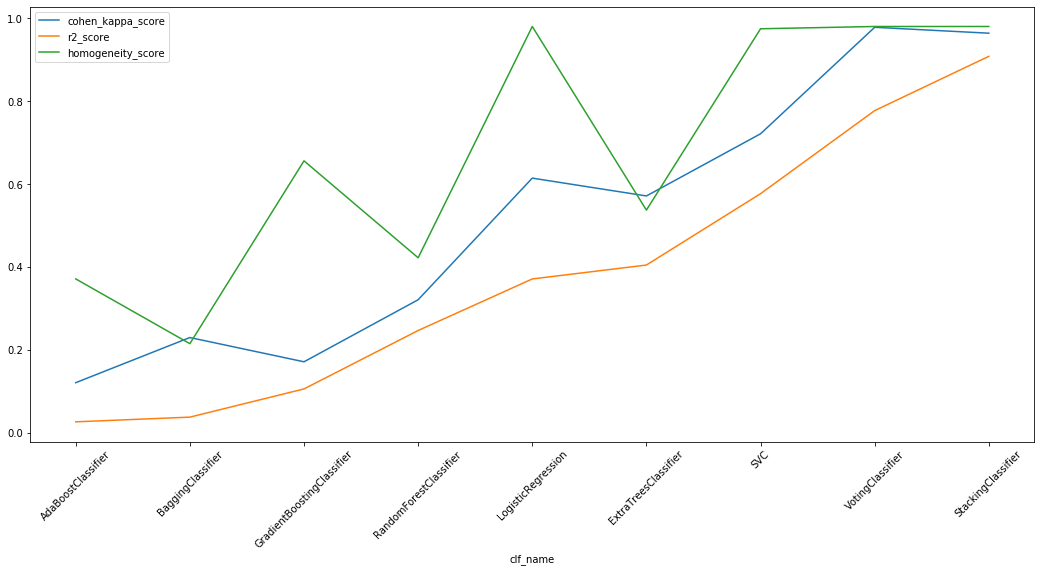

In [35]:

entropy_df = s.load_object('entropy_df')
metrics_list = s.load_object('metrics_list')
custom_metrics_list = ['boundary_diff', 'clf_yes_entropy', 'relative_yes_entropy']
columns_list = metrics_list + custom_metrics_list
columns_list = [cn for cn, s in sorted([(cn, entropy_df[cn].std()) for cn in columns_list], key=lambda x: x[1], reverse=True)][:3]
description_dict = s.load_object('description_dict')
for metric in columns_list:
    print('{}: {}'.format(metric, description_dict[metric]))
AxesSubplot_obj = entropy_df[columns_list].sort_values('r2_score', ascending=True).plot.line(rot=45, figsize=(18, 8))

balanced_accuracy_score: Compute the balanced accuracy
r2_score: R^2 (coefficient of determination) regression score function.


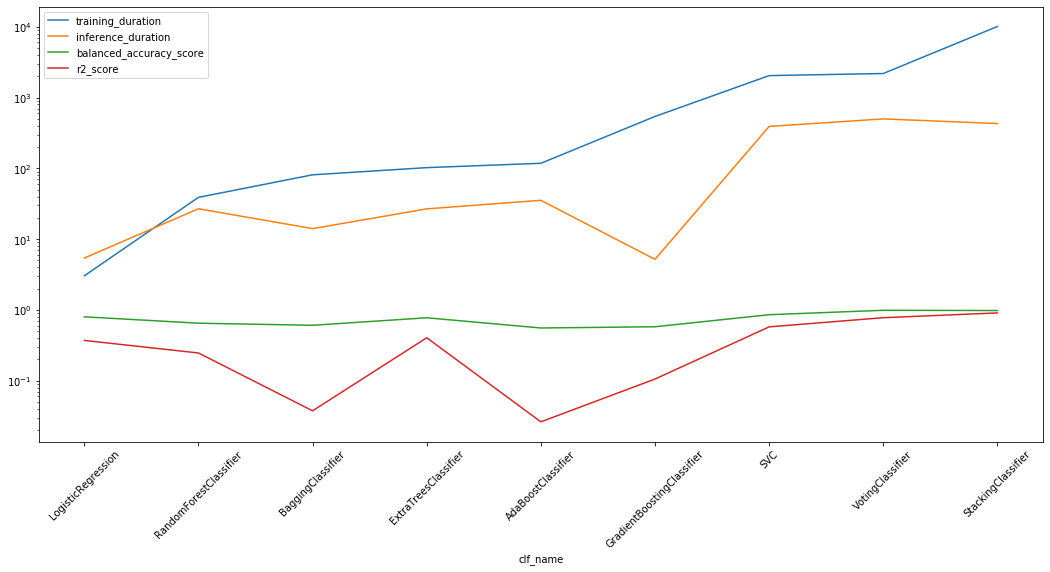

In [36]:

description_dict = s.load_object('description_dict')
columns_list = ['training_duration', 'inference_duration', 'balanced_accuracy_score', 'r2_score']
for metric in columns_list:
    if metric in description_dict:
        print('{}: {}'.format(metric, description_dict[metric]))
entropy_df = s.load_object('entropy_df')
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
AxesSubplot_obj = entropy_df[columns_list].sort_values('training_duration', ascending=True).plot.line(rot=45, ax=ax)

accuracy_score: Accuracy classification score.
balanced_accuracy_score: Compute the balanced accuracy


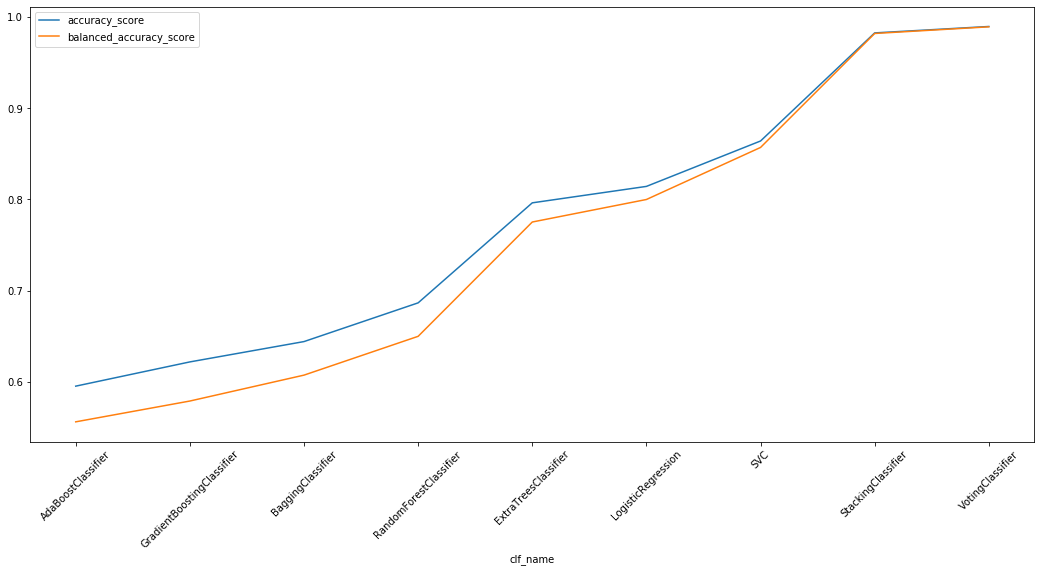

In [37]:

metrics_list = s.load_object('metrics_list')
columns_list = [cn for cn in metrics_list if 'accur' in cn.lower()]
for metric in columns_list:
    if metric in description_dict:
        print('{}: {}'.format(metric, description_dict[metric]))
AxesSubplot_obj = entropy_df[columns_list].sort_values('accuracy_score', ascending=True).plot.line(rot=45, figsize=(18, 8))

In [38]:

entropy_df[custom_metrics_list].sort_values('boundary_diff', ascending=False)

,boundary_diff,clf_yes_entropy,relative_yes_entropy
clf_name,,,
AdaBoostClassifier,-0.326660,7.501661,0.005136
VotingClassifier,-0.478308,7.500736,0.006958
RandomForestClassifier,-0.630000,7.496121,0.011526
GradientBoostingClassifier,-0.636707,7.487730,0.020336
ExtraTreesClassifier,-0.650000,7.492487,0.015704
LogisticRegression,-0.739466,7.485213,0.023357
StackingClassifier,-0.768875,7.500256,0.009413
BaggingClassifier,-0.800000,7.487856,0.021944
SVC,-0.965966,7.474945,0.044696


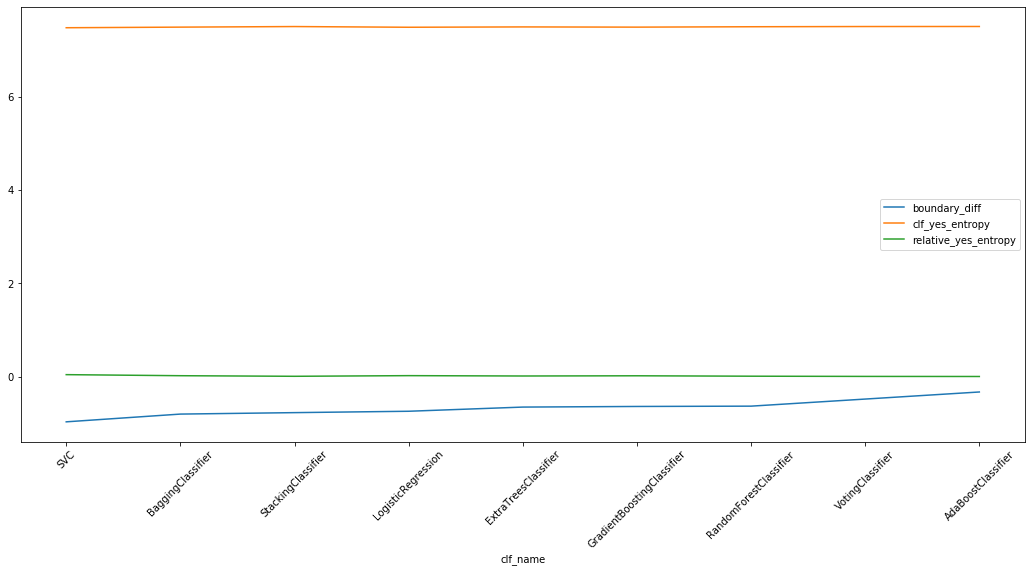

In [39]:

for metric in custom_metrics_list:
    if metric in description_dict:
        print('{}: {}'.format(metric, description_dict[metric]))
AxesSubplot_obj = entropy_df[custom_metrics_list].sort_values('boundary_diff', ascending=True).plot.line(rot=45, figsize=(18, 8))

In [3]:

entropy_df = s.load_object('entropy_df')
columns_list = ['training_duration', 'inference_duration', 'precision_score', 'recall_score']
entropy_df[columns_list].sort_values('precision_score', ascending=False)

,training_duration,inference_duration,precision_score,recall_score
clf_name,,,,
VotingClassifier,2187.502839,499.678591,0.988512,0.992312
StackingClassifier,10096.704018,429.701242,0.980906,0.987370
SVC,2042.894353,391.375785,0.847749,0.920373
LogisticRegression,3.037896,5.406613,0.779263,0.928611
ExtraTreesClassifier,102.434954,26.778679,0.744591,0.963756
RandomForestClassifier,38.955487,26.893659,0.643218,0.979132
BaggingClassifier,81.108137,14.087290,0.618702,0.937397
GradientBoostingClassifier,541.328005,5.184520,0.599385,0.963756
AdaBoostClassifier,117.990403,35.393264,0.588110,0.907194


precision_score: Compute the precision
recall_score: Compute the recall


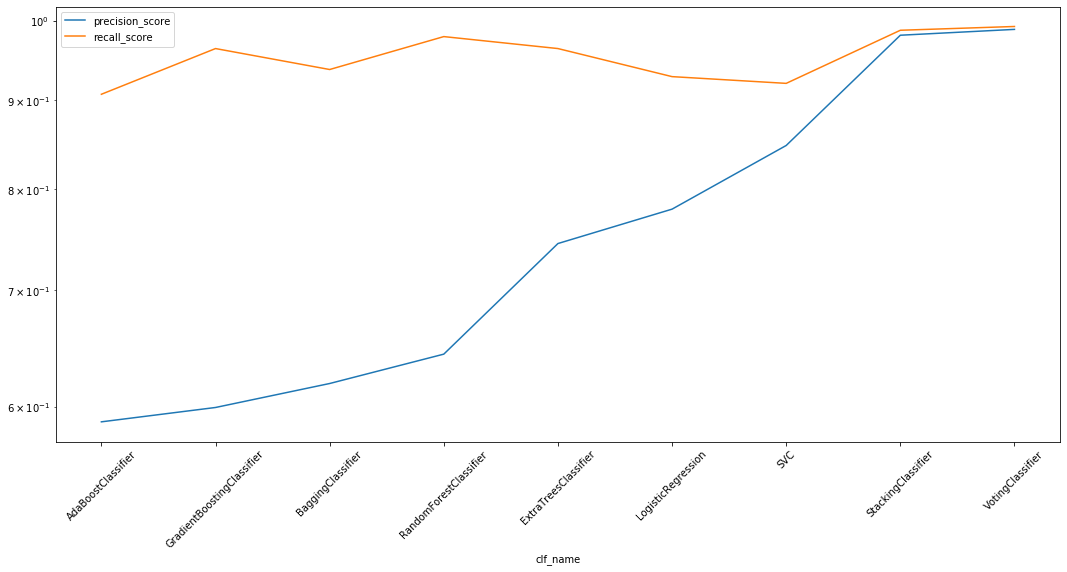

In [6]:

columns_list = ['precision_score', 'recall_score']
description_dict = s.load_object('description_dict')
for metric in columns_list:
    if metric in description_dict:
        print('{}: {}'.format(metric, description_dict[metric]))
entropy_df = s.load_object('entropy_df')
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
AxesSubplot_obj = entropy_df[columns_list].sort_values('precision_score', ascending=True).plot.line(rot=45, ax=ax)


---

In [8]:

LogisticRegression?

Init signature:
LogisticRegression(
    penalty='l2',
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containing 64-b

In [2]:

from sklearn.model_selection import GridSearchCV

GridSearchCV?

Init signature:
GridSearchCV(
    estimator,
    param_grid,
    scoring=None,
    n_jobs=None,
    iid='deprecated',
    refit=True,
    cv=None,
    verbose=0,
    pre_dispatch='2*n_jobs',
    error_score=nan,
    return_train_score=False,
)
Docstring:     
Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a "fit" and a "score" method.
It also implements "predict", "predict_proba", "decision_function",
"transform" and "inverse_transform" if they are implemented in the
estimator used.

The parameters of the estimator used to apply these methods are optimized
by cross-validated grid-search over a parameter grid.

Read more in the :ref:`User Guide <grid_search>`.

Parameters
----------
estimator : estimator object.
    This is assumed to implement the scikit-learn estimator interface.
    Either estimator needs to provide a ``score`` function,
    or ``scoring`` must be passed.

param_grid : dict or list of 